### 一、运用相关库获取上市公司 A 的股票基本数据、计算相应的衍生变量数据、通过相关性分析选取合适的衍生变量、可视化呈现数据、并生成 Excel 工作簿。

In [1]:
import pandas as pd
import numpy as np
import tushare as ts
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
plt.rcParams['font.family'] = ['Microsoft Yahei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
 # 运用 Tushare 库获取中国长城从 2023-01-01 至 2023-03-31 的股价变化（price_change）和成交量(volume)数据。
ts.set_token('54ffe0993a3933d988845320c0d327dea35036a21e232b8ab10a2490')
pro = ts.pro_api()

stock_code = '000066'
stock_name = '中国长城'
start_date = '2023-01-01'  
end_date = '2023-03-31'
stock_k = ts.get_hist_data(stock_code, start=start_date, end=end_date) 
stock_k[['price_change', 'volume']].head(5)

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


,price_change,volume
date,,
2023-03-31,0.21,995046.94
2023-03-30,-0.57,1548037.75
2023-03-29,-1.41,2358339.50
2023-03-28,-0.29,804752.50
2023-03-27,0.11,918147.50


In [3]:
stock_table = pd.DataFrame()  
stock_table['股票名称'] = '中国长城'
stock_table['价格变动'] = stock_k['price_change']
stock_table['成交量'] = stock_k['volume']
stock_table.head(3)

,股票名称,价格变动,成交量
date,,,
2023-03-31,NaN,0.21,995046.94
2023-03-30,NaN,-0.57,1548037.75
2023-03-29,NaN,-1.41,2358339.50


##### "如果您的输出是 NaN，可能是您的数据框中没有正确设置索引值。"—— GPT the Programmer

In [4]:
#按日期升序排列
stock_table = stock_table.sort_values(by='date', ascending=True)
stock_table.head(3)

,股票名称,价格变动,成交量
date,,,
2023-01-03,NaN,0.53,624985.19
2023-01-04,NaN,-0.05,426027.97
2023-01-05,NaN,0.11,408652.31


In [5]:
# 更改索引值，填入股票名称
stock_table.reset_index(drop=False, inplace=True)
stock_table['股票名称'] = '中国长城'
stock_table.head(3)

,date,股票名称,价格变动,成交量
0,2023-01-03,中国长城,0.53,624985.19
1,2023-01-04,中国长城,-0.05,426027.97
2,2023-01-05,中国长城,0.11,408652.31


In [6]:
# 根据以下两种方法计算从 2023-01-01 至 2023-03-31 的成交量涨跌幅：
# a) 采用当日交易量和昨日交易量的方法
stock_table['昨日成交量'] = stock_table['成交量'].shift(1)
stock_table['成交量涨跌幅1(%)'] = (stock_table['成交量']-stock_table['昨日成交量'])/stock_table['昨日成交量']*100
stock_table.tail(3)

,date,股票名称,价格变动,成交量,昨日成交量,成交量涨跌幅1(%)
56,2023-03-29,中国长城,-1.41,2358339.50,804752.50,193.051528
57,2023-03-30,中国长城,-0.57,1548037.75,2358339.50,-34.358995
58,2023-03-31,中国长城,0.21,995046.94,1548037.75,-35.722049


In [7]:
# b) 采用当日交易量和多日交易量的平均值的方法
five_mean = stock_table['成交量'].sort_index().rolling(5, min_periods=1).mean()
stock_table['成交量5日均值'] = five_mean
stock_table['成交量涨跌幅2(%)'] = (stock_table['成交量']-stock_table['成交量5日均值'])/stock_table['成交量5日均值']*100
stock_table.head(8)

,date,股票名称,价格变动,成交量,昨日成交量,成交量涨跌幅1(%),成交量5日均值,成交量涨跌幅2(%)
0,2023-01-03,中国长城,0.53,624985.19,NaN,NaN,624985.190000,0.000000
1,2023-01-04,中国长城,-0.05,426027.97,624985.19,-31.833910,525506.580000,-18.930041
2,2023-01-05,中国长城,0.11,408652.31,426027.97,-4.078526,486555.156667,-16.011103
3,2023-01-06,中国长城,-0.14,313560.53,408652.31,-23.269605,443306.500000,-29.267780
4,2023-01-09,中国长城,-0.06,265635.25,313560.53,-15.284220,407772.250000,-34.856958
5,2023-01-10,中国长城,0.02,269901.88,265635.25,1.606199,336755.588000,-19.852294
6,2023-01-11,中国长城,-0.33,396482.09,269901.88,46.898603,330846.412000,19.838715
7,2023-01-12,中国长城,0.11,341701.56,396482.09,-13.816647,317456.262000,7.637366


In [8]:
# 3) 通过皮尔逊相关系数分别进行两种成交量涨跌幅与股价变化的相关性分析，并选择出更优的成交量涨跌幅。
from scipy.stats import pearsonr

# 成交量涨幅1(%)和股价涨幅的相关性分析
corr = pearsonr(abs(stock_table['价格变动'][1:]), abs(stock_table['成交量涨跌幅1(%)'][1:]))
print('通过公式1计算的相关系数r值为' + str(corr[0]) + '，显著性水平P值为' + str(corr[1]))

# 成交量涨幅2(%)和股价涨幅的相关性分析
corr = pearsonr(abs(stock_table['价格变动']), abs(stock_table['成交量涨跌幅2(%)']))
print('通过公式2相关系数r值为' + str(corr[0]) + '，显著性水平P值为' + str(corr[1]))

通过公式1计算的相关系数r值为0.6340642172189692，显著性水平P值为9.12273643955028e-08
通过公式2相关系数r值为0.3825890588851773，显著性水平P值为0.0027850002829200205


######       结果显示，公式1计算出的成交量涨跌幅更优。

In [9]:
# 4) 在进行简单数据优化后，绘制成交量涨跌幅与股价变化的可视化图表（2 个 Y 轴的形式）。
target_columns = ['date', '股票名称','价格变动', '成交量涨跌幅1(%)']
final_table = stock_table[target_columns]
final_table = final_table.rename(columns={'成交量涨跌幅1(%)':'成交量涨跌幅(%)', 'date':'交易日期'})
final_table.head(3)

,交易日期,股票名称,价格变动,成交量涨跌幅(%)
0,2023-01-03,中国长城,0.53,NaN
1,2023-01-04,中国长城,-0.05,-31.833910
2,2023-01-05,中国长城,0.11,-4.078526


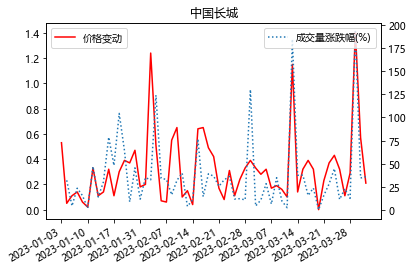

In [10]:
# 绘制第一个折线图：价格变动
plt.plot(final_table['交易日期'], final_table['价格变动'].apply(lambda x: abs(x)), label='价格变动', color='red')
plt.legend(loc='upper left') 

# 绘制第二个折线图：成交量涨跌幅(%)
plt.twinx()
plt.plot(final_table['交易日期'], final_table['成交量涨跌幅(%)'].apply(lambda x: abs(x)), label='成交量涨跌幅(%)', linestyle=':')
plt.legend(loc='upper right')

# 设置横轴刻度间隔为每五天显示一个刻度
plt.xticks(final_table['交易日期'][::5])

# 设置图片标题，自动调整x坐标轴刻度的角度并展示图片
plt.title('中国长城')  
plt.gcf().autofmt_xdate()  
plt.show()

In [11]:
# 5) 运用 xlwings 库将优化后的数据以及可视化图表导出至 Excel 工作簿。
import xlwings as xw
app = xw.App(visible=False)

wb = app.books.add()
sht = wb.sheets.add(stock_name)

In [12]:
# 填充数据
sht.range('A1').value = final_table.set_index('交易日期', inplace=False) # 在表中填入数据时将date设置为index，但不影响后续操作

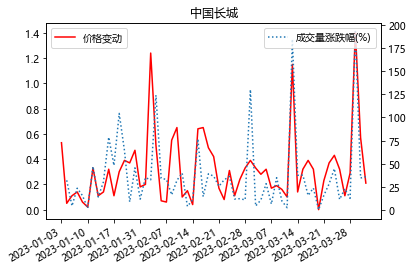

<Picture '中国长城' in <Sheet [工作簿10]中国长城>>

In [13]:
# 插入图片
fig = plt.figure()

## 绘制图片
# 绘制第一个折线图：价格变动
plt.plot(final_table['交易日期'], final_table['价格变动'].apply(lambda x: abs(x)), label='价格变动', color='red')
plt.legend(loc='upper left') 
# 绘制第二个折线图：成交量涨跌幅(%)
plt.twinx()
plt.plot(final_table['交易日期'], final_table['成交量涨跌幅(%)'].apply(lambda x: abs(x)), label='成交量涨跌幅(%)', linestyle=':')
plt.legend(loc='upper right')

# 设置横轴刻度间隔为每五天显示一个刻度
plt.xticks(final_table['交易日期'][::5])

# 设置图片标题，自动调整x坐标轴刻度的角度并展示图片
plt.title('中国长城')  
plt.gcf().autofmt_xdate()  
plt.show()

sht.pictures.add(fig, name='中国长城', update=True, left=300)

In [14]:
wb.save('中国长城数据分析及可视化.xlsx')
wb.close()
app.quit()
print('中国长城数据分析及可视化于Excel生成完毕')

中国长城数据分析及可视化于Excel生成完毕


### 二、运用相关库从搜狗资讯（https://news.sogou.com/china.shtml）获取中国长城的网页源代码，提取相应的标题、网址、来源和发布日期信息，进行简单的数据清洗，并生成文本文件

In [15]:
import requests
import re
import time
headers = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.0.0 Safari/537.36 Edg/112.0.1722.34'}

In [16]:
# 1) 运用 requests 库从搜狗资讯中获取中国长城 的第 1 页网页源代码。
url = 'https://www.sogou.com/sogou?query=中国长城&_ast=1681283503&_asf=www.sogou.com&w=01029901&pid=sogou-wsse-9fc36fa768a74fa9&duppid=1&cid=&interation=1728053249&s_from=result_up&sut=2595&sst0=1681283515316&lkt=0%2C0%2C0&sugsuv=003452ADDBD9F6A55DD27DA9932FF494&sugtime=1681283515316'
res = requests.get(url, headers=headers).text
res

'<!DOCTYPE html><html data-vtype="default"> <head><meta http-equiv="X-UA-Compatible" content="IE=Edge"><meta http-equiv="x-dns-prefetch-control" content="on"><meta charset="utf-8"><meta name="referrer" content="always"><meta name="viewport" content="width=device-width,minimum-scale=1,maximum-scale=1,user-scalable=no"><meta name="format-detection" content="telephone=no">  <link rel="dns-prefetch" href="//img01.sogoucdn.com"><link rel="dns-prefetch" href="//img02.sogoucdn.com"><link rel="dns-prefetch" href="//img03.sogoucdn.com"><link rel="dns-prefetch" href="//img04.sogoucdn.com"><link rel="dns-prefetch" href="//dlweb.sogoucdn.com"><link rel="dns-prefetch" href="//search.sogoucdn.com"><link rel="preconnect" href="//img01.sogoucdn.com"><link rel="preconnect" href="//img02.sogoucdn.com"><link rel="preconnect" href="//img03.sogoucdn.com"><link rel="preconnect" href="//img04.sogoucdn.com"><link rel="preconnect" href="//dlweb.sogoucdn.com"><link rel="dns-prefetch" href="//search.sogoucdn.com

In [17]:
# 2) 编写正则表达式获取新闻标题、网址、来源和发布日期信息。

# 获取新闻标题
p_title = '<h3 class="vr-title">.*?<em>(.*?)</a>'
title = re.findall(p_title, res, re.S)
title

['<!--red_beg-->中国长城<!--red_end--></em>000066',
 '<!--red_beg-->中国长城<!--red_end--></em>(000066.SZ)',
 '<!--red_beg-->中国长城<!--red_end--></em> 000066',
 '<!--red_beg-->中国长城<!--red_end--></em>(000066)历史资金流向一览',
 '<!--red_beg-->中国长城<!--red_end--></em>(000066)个股行情,分析,要闻-股票行情中心-金融界',
 '<!--red_beg-->长城<!--red_end--></em>',
 '<!--red_beg-->中国长城<!--red_end--></em>:用中国智造构筑不朽的长城',
 '<!--red_beg-->中国长城<!--red_end--></em>_电子产品世界',
 '<!--red_beg-->长城<!--red_end--></em>的介绍 <em><!--red_beg-->长城<!--red_end--></em>的简介',
 '<!--red_beg-->中国长城<!--red_end--></em> 股东大会现场会议登记起始']

In [18]:
# 获取网址
p_href='<h3 class="vr-title">.*?<a id=".*? href="(.*?)">.*?</h3>'
href = re.findall(p_href, res, re.S)
href

['/link?url=AZ5lEp6zQ3utpkDnt6hq49hidTBh4atIqtTrSJQZ2SsPwuMKQHj6mq3mlRzfPLR2',
 '/link?url=hedJjaC291P33igiXMgxhPGAKHZRnahNRxZAmZ-w-u_bG10kMHk35GIGIjUT39EMm8Nt1AcKOHd0OvoG4hjEUw..',
 '/link?url=AZ5lEp6zQ3utpkDnt6hq49hidTBh4atImfdQESRvbeTM6GwL-5wKag_C4wpAePqareaVHN88tHY.',
 '/link?url=WaeIF24cBDu3hP1y3b24hf4T17ln4fKRt9wdBjT9t9ACX-uSafO7riHmfGkNvdZG',
 '/link?url=hedJjaC291OWZ7H_sAB2vVPGSRJSV4PNUDKgjdzG2O9OHPWuOKJuxbbAp6VRqT6Q',
 '/link?url=DSOYnZeCC_qaBOTFv-fa6kqPLIKmdU_WaTfxcQkjJFX-sdwKgLfq7BOnfrjeOMdgoQ1NXon9Qx0ttGmULK9rShQ89sWzl3Yg',
 '/link?url=DSOYnZeCC_qCfDXPlAOgYmQJ6AJM-tu1cECFjUNUnyxatYjTb-0NakiYzaQ_noD_hkHjrixFMB430plpqlLpMvHmd5567V-1So0-wxpAQqezYN_PUGtKHof99oRuom_o',
 '/link?url=DSOYnZeCC_ozwY7GPWU2kvTkpBfe_PStb5pgNaVLL1hRBTuk2ofMpKcPXustxIPD7OZm6Md1u5W_wSgfDrcZUw3Wg6CWB4aUerzUdoVtMSH_Sjo-KaSLvA..',
 '/link?url=hedJjaC291OyiGvgbfIkdxeBP0apGOsBEilNBdVAUAlNHFsMN1UMbJAbVmFv2wLk',
 '/link?url=hedJjaC291OEkOgLHzjfJEKCQsLDbATHezCn5xdhDGpsJBBP0lyD0YmQN-lOyUWj']

In [19]:
### 补全网址字符串
for i in range(len(href)):
    href[i] = 'https://www.sogou.com'+ href[i]

href

['https://www.sogou.com/link?url=AZ5lEp6zQ3utpkDnt6hq49hidTBh4atIqtTrSJQZ2SsPwuMKQHj6mq3mlRzfPLR2',
 'https://www.sogou.com/link?url=hedJjaC291P33igiXMgxhPGAKHZRnahNRxZAmZ-w-u_bG10kMHk35GIGIjUT39EMm8Nt1AcKOHd0OvoG4hjEUw..',
 'https://www.sogou.com/link?url=AZ5lEp6zQ3utpkDnt6hq49hidTBh4atImfdQESRvbeTM6GwL-5wKag_C4wpAePqareaVHN88tHY.',
 'https://www.sogou.com/link?url=WaeIF24cBDu3hP1y3b24hf4T17ln4fKRt9wdBjT9t9ACX-uSafO7riHmfGkNvdZG',
 'https://www.sogou.com/link?url=hedJjaC291OWZ7H_sAB2vVPGSRJSV4PNUDKgjdzG2O9OHPWuOKJuxbbAp6VRqT6Q',
 'https://www.sogou.com/link?url=DSOYnZeCC_qaBOTFv-fa6kqPLIKmdU_WaTfxcQkjJFX-sdwKgLfq7BOnfrjeOMdgoQ1NXon9Qx0ttGmULK9rShQ89sWzl3Yg',
 'https://www.sogou.com/link?url=DSOYnZeCC_qCfDXPlAOgYmQJ6AJM-tu1cECFjUNUnyxatYjTb-0NakiYzaQ_noD_hkHjrixFMB430plpqlLpMvHmd5567V-1So0-wxpAQqezYN_PUGtKHof99oRuom_o',
 'https://www.sogou.com/link?url=DSOYnZeCC_ozwY7GPWU2kvTkpBfe_PStb5pgNaVLL1hRBTuk2ofMpKcPXustxIPD7OZm6Md1u5W_wSgfDrcZUw3Wg6CWB4aUerzUdoVtMSH_Sjo-KaSLvA..',
 'https://ww

In [20]:
# 获取来源及发布日期
p_info = '<div class="fz-mid">.*?<span>(.*?)</div>'
info = re.findall(p_info, res, re.S)
info

['东方财富网</span><span>2023-4-6</span>\n                    </p>\n                ',
 '新浪财经</span><span>1997年6月26日</span>\n                    </p>\n                ',
 '东方财富网</span><span>2022年6月30日</span>\n                    </p>\n                ',
 '东方财富网</span><span>1天前</span>\n                    </p>\n                ',
 '金融界</span><span>2023年3月31日</span>\n                    </p>\n                ',
 '国务院新闻办公室</span><span>2010年7月19日</span>\n                    </p>\n                ',
 '国有资产监督委员会</span><span>2021年5月27日</span>\n                    </p>\n                ',
 '电子产品世界</span><span>2023-4-6</span>\n                    </p>\n                ',
 '天气网</span><span>2022年5月31日</span>\n                    </p>\n                ',
 '云财经网</span><span>2020年3月12日</span>\n                    </p>\n                ']

In [21]:
# 3) 对获取的新闻信息进行简单的数据清洗。
source = []
date = []
for i in range(len(title)):
    title[i] = re.sub('<.*?>', '', title[i])
    info[i] = info[i].strip()
    info[i] = re.sub('<.*?>', ' ', info[i]) #将info中的source和date用空格分开
    source.append(info[i].split()[0])
    date.append(info[i].split()[1])
    
    print(str(i + 1) + '.' + title[i] + '(' + source[i] + ' '+ date[i] + ')')
    print(href[i])

1.中国长城000066(东方财富网 2023-4-6)
https://www.sogou.com/link?url=AZ5lEp6zQ3utpkDnt6hq49hidTBh4atIqtTrSJQZ2SsPwuMKQHj6mq3mlRzfPLR2
2.中国长城(000066.SZ)(新浪财经 1997年6月26日)
https://www.sogou.com/link?url=hedJjaC291P33igiXMgxhPGAKHZRnahNRxZAmZ-w-u_bG10kMHk35GIGIjUT39EMm8Nt1AcKOHd0OvoG4hjEUw..
3.中国长城 000066(东方财富网 2022年6月30日)
https://www.sogou.com/link?url=AZ5lEp6zQ3utpkDnt6hq49hidTBh4atImfdQESRvbeTM6GwL-5wKag_C4wpAePqareaVHN88tHY.
4.中国长城(000066)历史资金流向一览(东方财富网 1天前)
https://www.sogou.com/link?url=WaeIF24cBDu3hP1y3b24hf4T17ln4fKRt9wdBjT9t9ACX-uSafO7riHmfGkNvdZG
5.中国长城(000066)个股行情,分析,要闻-股票行情中心-金融界(金融界 2023年3月31日)
https://www.sogou.com/link?url=hedJjaC291OWZ7H_sAB2vVPGSRJSV4PNUDKgjdzG2O9OHPWuOKJuxbbAp6VRqT6Q
6.长城(国务院新闻办公室 2010年7月19日)
https://www.sogou.com/link?url=DSOYnZeCC_qaBOTFv-fa6kqPLIKmdU_WaTfxcQkjJFX-sdwKgLfq7BOnfrjeOMdgoQ1NXon9Qx0ttGmULK9rShQ89sWzl3Yg
7.中国长城:用中国智造构筑不朽的长城(国有资产监督委员会 2021年5月27日)
https://www.sogou.com/link?url=DSOYnZeCC_qCfDXPlAOgYmQJ6AJM-tu1cECFjUNUnyxatYjTb-0NakiYzaQ_noD_hkHjrixFMB4

In [22]:
# 4) 尝试从搜狗资讯中获取中国长城 的前 3 页网页源代码，同时完成 2)和3)中的内容（新闻信息的提取和简单数据清洗）。

## 定义搜狗新闻爬取函数
def crawl_on_sogou(page):
    url = 'https://www.sogou.com/sogou?query=中国长城&pid=sogou-wsse-9fc36fa768a74fa9&duppid=1&cid=&interation=1728053249&s_from=result_up&sut=1521&sst0=1681283754251&lkt=0%2C0%2C0&sugsuv=003452ADDBD9F6A55DD27DA9932FF494&sugtime=1681283754251&page='+ str(page) +'&ie=utf8&w=01029901&dr=1'
    # 获取源代码
    res = requests.get(url, headers=headers).text
    
    # 获取信息
    p_title = '<h3 class="vr-title">.*?<em>(.*?)</a>'
    p_href='<h3 class="vr-title">.*?<a id=".*? href="(.*?)">.*?</h3>'
    p_info = '<div class="fz-mid">.*?<span>(.*?)</div>'
    title = re.findall(p_title, res, re.S)
    href = re.findall(p_href, res, re.S)
    info = re.findall(p_info, res, re.S)
    
    # 数据清洗
    source = []
    date = []
    for i in range(len(title)):
        title[i] = re.sub('<.*?>', '', title[i])
        href[i] = 'https://www.sogou.com'+ href[i]# 补全网址字符串
        info[i] = info[i].strip()
        info[i] = re.sub('<.*?>', ' ', info[i]) # 将info中的source和date用空格分开
        source.append(info[i].split()[0])
        date.append(info[i].split()[1])

        #print(str(i + 1) + '.' + title[i] + '(' + source[i] + ' '+ date[i] + ')')
        #print(href[i])
        
    ## 5) 将 4)中的数据信息保存到一个文本文件中。
    file = open('中国长城数据挖掘报告.txt', 'a')
    file.write('Page '+ str(page+1) + ' data mining accomplished' + '\n' + '\n')
    for i in range(len(title)):
        file.write(str(i + 1) + '.' + title[i] + '(' + source[i] + ' '+ date[i] + ')' + '\n')
        file.write(href[i] + '\n')
    file.write('——————————————————————————————' + '\n' + '\n')
    file.close()

In [23]:
for i in range(3):
    try: 
        crawl_on_sogou(i)
        time.sleep(2)
        print('第'+str(i+1)+'页爬取成功')
    except:
        print('第'+str(i+1)+'页爬取失败')

第1页爬取成功
第2页爬取成功
第3页爬取成功


### 3. 运用相关库从东方财富网个股股吧（https://so.eastmoney.com/TieZi/s?keyword=）中获取 中国长城的网页源代码，提取相应的标题、网址、来源和发布日期等信息，进行简单的数据清洗，并生成文本文件。

In [24]:
from selenium import webdriver
from selenium.webdriver.common.by import By

In [25]:
# 1) 运用 selenium 库从东方财富个股吧中获取中国长城的第 1 页网页源代码。
browser = webdriver.Edge() # Chrome卸载了，只能用Edge
browser.get("https://so.eastmoney.com/TieZi/s?keyword=000066")
data = browser.page_source
data

'<html><head>\n  <meta charset="utf-8">\n  <meta http-equiv="X-UA-Compatible" content="IE=edge,chrome=1">\n  <meta name="viewport" content="width=device-width, initial-scale=1.0">\n  <title>搜索结果 - 东方财富网</title>\n  <!-- make at 4/14/2023, 4:31:46 PM, s_num: 201，use 0ms -->\n  <link rel="stylesheet" href="/newstatic/css/search_main.css">\n  <link rel="stylesheet" href="/newstatic/js/libs/daterangepicker.css">\n<style>body {\n  margin-top: 43px;\n}\n\n.topnavmain {\n  width: 1200px;\n  margin: 0 auto;\n  background-color: #fff;\n}\n\nhtml,\nhtml body {\n  _background-image: url(about:blank);\n  _background-attachment: fixed;\n}\n\n.top-nav-wrap ul {\n  padding: 0;\n  margin: 0;\n  list-style: none;\n}\n\n.top-nav-wrap {\n  font-size: 12px;\n  font-family: simsun;\n  height: 30px;\n  background-color: #f7f7f7;\n  border-top: 2px solid #ff4901;\n  border-bottom: 1px solid #dfdfdf;\n  position: fixed !important;\n  position: absolute;\n  left: 0;\n  top: 0;\n  _top: expression(eval(document.

In [26]:
# 随手关闭养成好习惯
browser.quit()

In [27]:
# 2) 编写正则表达式获取新闻标题、网址、来源和发布日期等信息。

## 获取新闻标题
p_title = '<div class="article_item"><div class="article_title"><span class="articel_ba">.*?</span><a href=".*?" target="_blank" tracker-eventcode="dfcfwss.ssh.ryq.nrdj" tracker-extinfo="{\'LocModuleKey\': \'股吧-搜贴\',\'searchKeyWord\': \'000066\'}">(.*?)</a></div><div class="article_content"><label>'
title = re.findall(p_title, data, re.S)
print(len(title))
title

10


['都搞了几十年了<em>长城电脑</em>了，销量还上不去，反而成本倒是上去了。',
 '长城万里长，都是一块块砖垒起的，今天<em>长城电脑</em>一点又一点叱食了不少筹码…',
 '<em>长城电脑</em>又到新一轮上涨周期，压盘的有胆量今天收盘之前放在那里不要动',
 '为什么<em>长城电脑</em>得不到业界认可？我记得以前老宋在的时候口碑还是很好的呢。',
 '中国长城＝长城信息＋<em>长城电脑</em>中国电子信息集团控股芯片服务器，算力时代的军工尚品！',
 '很长时间以来都说<em>长城电脑</em>主要就是搞信息安全，数字货币风口不知道与其关联大不大？',
 '这种垃圾公司也有人看好真牛逼，就问你<em>长城电脑</em>你自己会买吗？政F和企业里面最垃圾的',
 '昨日被收割了许多韮菜，心中不甘，今天匆忙吃回头草，恶庄顺手而为打压岀许多恐慌割肉',
 '昨天就觉得现在的同方股份各方面有点类似三年前的另外一只自主可控的民族品牌0000',
 '其实几年前运营商中标前几名里还是能够看到长城的身影的。银行招标里长城也是市场中标']

In [28]:
## 获取新闻网址
p_href = '<div class="article_item"><div class="article_title"><span class="articel_ba">.*?</span><a href="(.*?)" target="_blank" tracker-eventcode="dfcfwss.ssh.ryq.nrdj" tracker-extinfo="{\'LocModuleKey\': \'股吧-搜贴\',\'searchKeyWord\': \'000066\'}">.*?</a></div><div class="article_content"><label>'
href = re.findall(p_href, data, re.S)
href

['http://guba.eastmoney.com/news,000066,1266128708.html',
 'http://guba.eastmoney.com/news,000066,1275184986.html',
 'http://guba.eastmoney.com/news,000066,1242597665.html',
 'http://guba.eastmoney.com/news,000066,1257821571.html',
 'http://guba.eastmoney.com/news,000066,1280645116.html',
 'http://guba.eastmoney.com/news,000066,1234735183.html',
 'http://guba.eastmoney.com/news,000066,1270215249.html',
 'http://guba.eastmoney.com/news,000066,1273803259.html',
 'http://guba.eastmoney.com/news,600100,1273555558.html',
 'http://guba.eastmoney.com/news,000066,1266943210.html']

In [29]:
## 获取来源
p_source = '<div class="article_item"><div class="article_title"><span class="articel_ba">(.*?)</span><a href=".*?" target="_blank" tracker-eventcode="dfcfwss.ssh.ryq.nrdj" tracker-extinfo="{\'LocModuleKey\': \'股吧-搜贴\',\'searchKeyWord\': \'000066\'}">.*?</a></div><div class="article_content"><label>'
source = re.findall(p_source, data, re.S)
source

['【中国长城】',
 '【中国长城】',
 '【中国长城】',
 '【中国长城】',
 '【中国长城】',
 '【中国长城】',
 '【中国长城】',
 '【中国长城】',
 '【同方股份】',
 '【中国长城】']

In [30]:
## 获取发布时间
p_time = '<div class="article_item"><div class="article_title"><span class="articel_ba">.*?</span><a href=".*?" target="_blank" tracker-eventcode="dfcfwss.ssh.ryq.nrdj" tracker-extinfo="{\'LocModuleKey\': \'股吧-搜贴\',\'searchKeyWord\': \'000066\'}">.*?</a></div><div class="article_content"><label>(.*?)</label>'
time = re.findall(p_time, data, re.S)
time

['2023-01-02 14:09:30',
 '2023-02-08 10:48:25',
 '2022-11-03 14:19:22',
 '2022-12-09 18:24:10',
 '2023-02-25 20:16:29',
 '2022-10-13 10:21:26',
 '2023-01-14 10:37:58',
 '2023-02-03 09:59:43',
 '2023-02-02 14:11:58',
 '2023-01-04 17:40:35']

In [31]:
# 3) 对获取的新闻信息进行简单的数据清洗。
for i in range(len(title)):
    title[i] = re.sub('<.*?>', '', title[i])
    source[i] = source[i][1:-1] # 去掉每个source字符串两边的中括号"【】"

In [32]:
# 4) 将数据信息保存到一个文本文件中。
file = open('中国长城舆情信息.txt', 'a')
for i in range(len(title)):
    file.write(str(i + 1) + '.' + title[i] + '(' + source[i] + ' '+ time[i] + ')' + '\n')
    file.write(href[i] + '\n')
    print(str(i + 1) + '.' + title[i] + '(' + source[i] + ' '+ time[i] + ')')
    print(href[i])
file.close()

1.都搞了几十年了长城电脑了，销量还上不去，反而成本倒是上去了。(中国长城 2023-01-02 14:09:30)
http://guba.eastmoney.com/news,000066,1266128708.html
2.长城万里长，都是一块块砖垒起的，今天长城电脑一点又一点叱食了不少筹码…(中国长城 2023-02-08 10:48:25)
http://guba.eastmoney.com/news,000066,1275184986.html
3.长城电脑又到新一轮上涨周期，压盘的有胆量今天收盘之前放在那里不要动(中国长城 2022-11-03 14:19:22)
http://guba.eastmoney.com/news,000066,1242597665.html
4.为什么长城电脑得不到业界认可？我记得以前老宋在的时候口碑还是很好的呢。(中国长城 2022-12-09 18:24:10)
http://guba.eastmoney.com/news,000066,1257821571.html
5.中国长城＝长城信息＋长城电脑中国电子信息集团控股芯片服务器，算力时代的军工尚品！(中国长城 2023-02-25 20:16:29)
http://guba.eastmoney.com/news,000066,1280645116.html
6.很长时间以来都说长城电脑主要就是搞信息安全，数字货币风口不知道与其关联大不大？(中国长城 2022-10-13 10:21:26)
http://guba.eastmoney.com/news,000066,1234735183.html
7.这种垃圾公司也有人看好真牛逼，就问你长城电脑你自己会买吗？政F和企业里面最垃圾的(中国长城 2023-01-14 10:37:58)
http://guba.eastmoney.com/news,000066,1270215249.html
8.昨日被收割了许多韮菜，心中不甘，今天匆忙吃回头草，恶庄顺手而为打压岀许多恐慌割肉(中国长城 2023-02-03 09:59:43)
http://guba.eastmoney.com/news,000066,1273803259.html
9.昨天就觉得现在的同方股份各方面有点类似三年前的另外一只自主可控的民族品牌0000(同

### 四、运用相关库获取 中国长城 和深证成指的股票价格数据，分析其基本特征，进行正态性检验，并实施贝叶斯回归。

#### 1) 运用 Tushare 库获取 中国长城和深证成指(399001)从 2022-01-01 至 2022-12-31 的股票价格数据(收盘价)。

In [33]:
import pandas as pd
import numpy as np
from pylab import mpl, plt
import scipy.stats as scs

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

plt.style.use('seaborn')
plt.rcParams['font.family'] = ['Microsoft Yahei']
plt.rcParams['axes.unicode_minus'] = False

In [34]:
# 1) 运用 Tushare 库获取中国长城和深证成指(399001)从 2022-01-01 至 2022-12-31 的股票价格数据(收盘价)。
import tushare as ts
ts.set_token('54ffe0993a3933d988845320c0d327dea35036a21e232b8ab10a2490')
pro = ts.pro_api()

start_date = '2022-01-01'  
end_date = '2022-12-31'

stock_code = '000066'
stock_name = '中国长城'
stock_k = ts.get_hist_data(stock_code, start=start_date, end=end_date) 
stock_k[['close']].head(3)

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


,close
date,
2022-12-30,10.2
2022-12-29,10.2
2022-12-28,10.1


In [35]:
index_code = '399001'
index_name = '深证成指'
index_k = ts.get_hist_data(index_code, start=start_date, end=end_date)
index_k[['close']].head(3)

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


,close
date,
2022-12-30,11015.99
2022-12-29,10996.41
2022-12-28,11010.53


In [36]:
all_data = pd.DataFrame()
all_data['stock_price'] = stock_k['close']
all_data['index_price'] = index_k['close']
all_data = all_data.sort_values(by='date', ascending=True) #按日期升序排列
all_data.head(5)

,stock_price,index_price
date,,
2022-01-04,14.67,14791.31
2022-01-05,14.93,14525.76
2022-01-06,14.88,14429.51
2022-01-07,14.50,14343.65
2022-01-10,15.43,14406.97


In [37]:
# 2) 将中国长城和深证成指的股票价格数据规范化，并绘制股票规范化价格数的线图和散点图。

#价格数据规范化
all_data = all_data / all_data.iloc[0] * 100
all_data.head(5)

,stock_price,index_price
date,,
2022-01-04,100.000000,100.000000
2022-01-05,101.772324,98.204689
2022-01-06,101.431493,97.553969
2022-01-07,98.841172,96.973493
2022-01-10,105.180641,97.401582


In [38]:
## 将此步骤数据保存，方便后续切换环境操作
all_data.to_csv('all_data.csv')

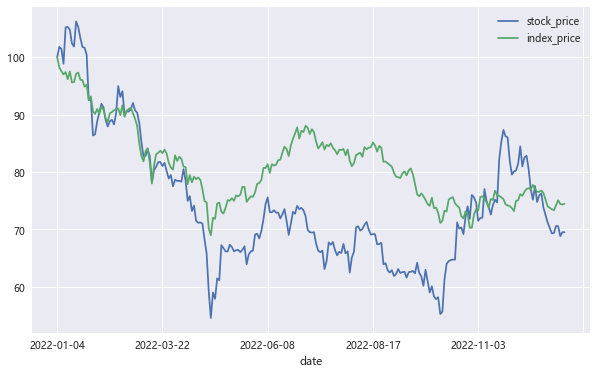

In [39]:
# 绘制线图
all_data.plot(figsize=(10, 6)) 

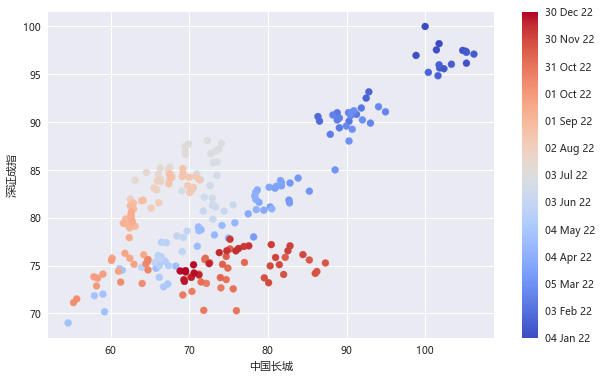

In [41]:
# 绘制散点图
mpl_dates = mpl.dates.date2num(pd.to_datetime(all_data.index))
'''
    原代码:‘all_data.index.to_pydatetime()’将索引转换为Python datetime对象，产生报错'Index' object has no attribute 'to_pydatetime'
    
    “要将索引转换为Python datetime对象，您可以使用pd.to_datetime()方法来转换，
    例如：mpl_dates = mpl.dates.date2num(pd.to_datetime(all_data.index))”
                                                                            —— GPT the Programmer
'''

plt.figure(figsize=(10, 6))
plt.scatter(all_data['stock_price'], all_data['index_price'], c=mpl_dates, marker='o', cmap='coolwarm')
plt.xlabel('中国长城')
plt.ylabel('深证成指')
plt.colorbar(ticks=mpl.dates.DayLocator(interval=30), format=mpl.dates.DateFormatter('%d %b %y'))

In [42]:
# 3) 计算中国长城和深证成指的对数收益率，并进行正态性检验（3 种方法选其中 2 种）。

# 生成对数收益率模拟数据(log("S_t"/ S_s)
log_returns = np.log(all_data / all_data.shift(1))
log_returns.head(5)

,stock_price,index_price
date,,
2022-01-04,NaN,NaN
2022-01-05,0.017568,-0.018116
2022-01-06,-0.003355,-0.006648
2022-01-07,-0.025869,-0.005968
2022-01-10,0.062165,0.004405


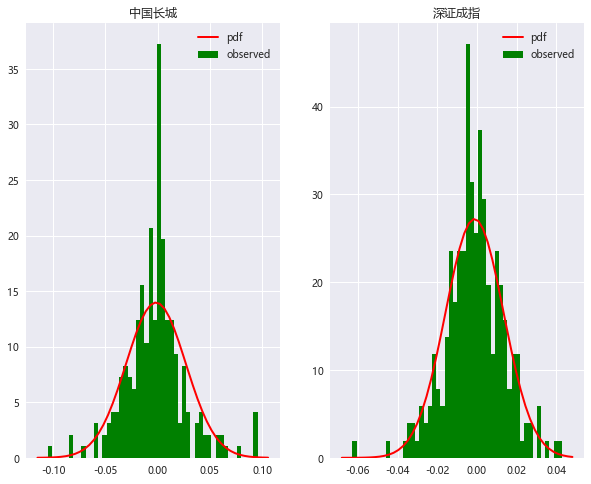

In [43]:
# 正态性检验方法1：对比频率分布(直方图)与理论化正态密度函数(PDF)
plt.figure(figsize=(10, 8))
log_returns1 = log_returns.dropna()

plt.subplot(121)
plt.hist(log_returns1['stock_price'], bins=50, density=True, label='observed', color='g')
plt.title('中国长城')
x = np.linspace(plt.axis()[0], plt.axis()[1])
plt.plot(x, scs.norm.pdf(x, log_returns1['stock_price'].mean(),log_returns1['stock_price'].std()), 'r', lw=2.0, label='pdf')
plt.legend()

plt.subplot(122)
plt.hist(log_returns1['index_price'], bins=50, density=True, label='observed', color='g')
plt.title('深证成指')
x = np.linspace(plt.axis()[0], plt.axis()[1])
plt.plot(x, scs.norm.pdf(x, log_returns1['index_price'].mean(),log_returns1['index_price'].std()), 'r', lw=2.0, label='pdf')
plt.legend()

Text(0, 0.5, 'sample quantiles')

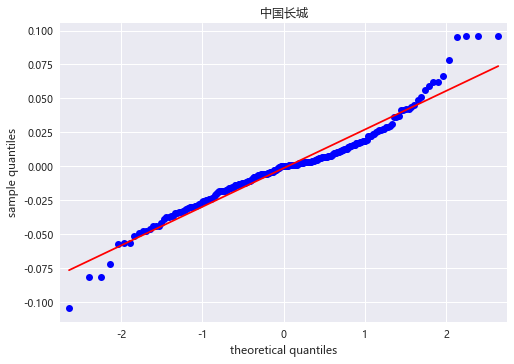

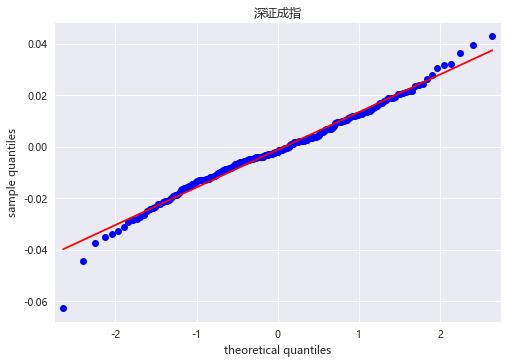

In [44]:
# 正态性检验方法2：对比样本分位数值与理论分位数值(QQ图)

import statsmodels.api as sm

sm.qqplot(log_returns['stock_price'].dropna(), line='s')
plt.title('中国长城')
plt.xlabel('theoretical quantiles')
plt.ylabel('sample quantiles')

sm.qqplot(log_returns['index_price'].dropna(), line='s')
plt.title('深证成指')
plt.xlabel('theoretical quantiles')
plt.ylabel('sample quantiles')

In [1]:
# 4) 运用 pymc3 库对中国长城和深证成指的股票价格实施贝叶斯回归（中国长城的股票规范化价格为 x 值，深证成指的股票规范化价格为 y 值），
    # 输出统计结果，并绘制后验分布及轨迹图，和贝叶斯回归线。

import pandas as pd
import numpy as np
from pylab import mpl, plt

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

plt.style.use('seaborn')
plt.rcParams['font.family'] = ['Microsoft Yahei']
plt.rcParams['axes.unicode_minus'] = False

all_data = pd.read_csv('all_data.csv')# 切换环境后，读取此前保存数据

In [2]:
# 贝叶斯回归
# 回归模型和MCMC采样代码
import pymc3 as pm
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=20)
    beta = pm.Normal('beta', mu=0, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    y_est = alpha + beta * all_data['stock_price'].values
    likelihood = pm.Normal('index_price', mu=y_est, sd=sigma, observed=all_data['index_price'].values)
    
    start = pm.find_MAP()
    step = pm.NUTS()
    trace = pm.sample(50, tune=200, cores=1, chains=1, start=start, progressbar=True)
    
# 贝叶斯回归结果
pm.summary(trace) 

WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Only 50 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, beta, alpha]


Sampling 1 chain for 200 tune and 50 draw iterations (200 + 50 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.9491624761867128, but should be close to 0.8. Try to increase the number of tuning steps.
Got error No model on context stack. trying to find log_likelihood in translation.
arviz - WARNING - Shape validation failed: input_shape: (1, 50), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,48.305,1.882,45.768,51.630,0.766,0.573,8.0,33.0,NaN
beta,0.439,0.025,0.395,0.471,0.010,0.007,10.0,46.0,NaN
sigma,4.876,0.225,4.474,5.245,0.110,0.084,6.0,14.0,NaN


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

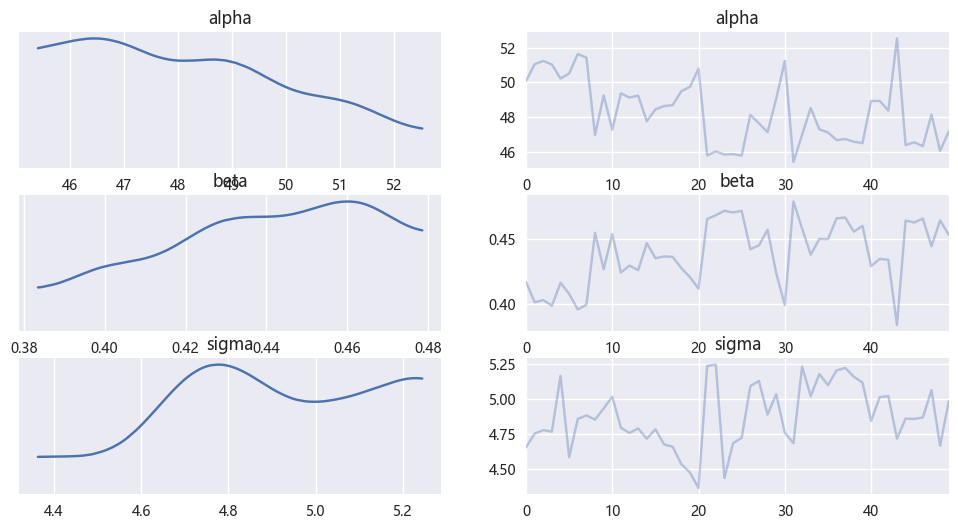

In [3]:
# 绘制后验分布及轨迹图
pm.traceplot(trace)

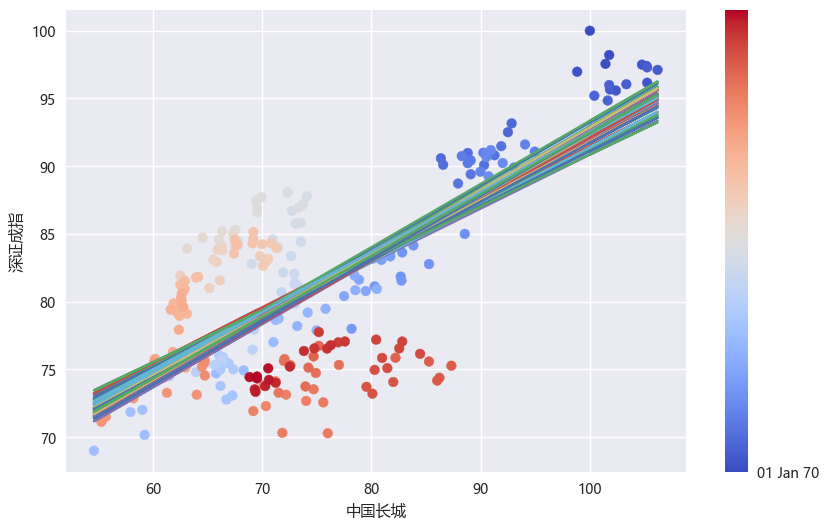

In [4]:
# 绘制贝叶斯回归线
mpl_dates = mpl.dates.date2num(pd.to_datetime(all_data.index))

plt.figure(figsize=(10, 6))
plt.scatter(all_data['stock_price'], all_data['index_price'], c=mpl_dates, marker='o', cmap='coolwarm')
plt.xlabel('中国长城')
plt.ylabel('深证成指')
for i in range(len(trace)):
    plt.plot(all_data['stock_price'], trace['alpha'][i] + trace['beta'][i] * all_data['stock_price'])
plt.colorbar(ticks=mpl.dates.DayLocator(interval=250), format=mpl.dates.DateFormatter('%d %b %y'))